## Noções de IA - Trabalho 1 - Regressão Linear na qualidade de vinho
##### Integrantes:
            - Lucas Corrêa Boaventura           - 211038262
            - Alexandre Castanho Sampaio Rocha  - 211027536

### Bibliotecas

In [20]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from d2l import tensorflow as d2l
import random

### Classes


In [21]:
class LinearRegression(d2l.Module): #@save
    """The linear regression model implemented with high-level APIs."""
    """Do d2l"""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

In [22]:
class LinearRegressionData(d2l.DataModule): #@save
    """Data for linear regression."""
    def __init__(self, nInputs,data,num_train=5197, num_val=1300, batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        self.X=data[:,0:nInputs]
        self.y=data[:,nInputs]

@d2l.add_to_class(d2l.DataModule) #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
    buffer_size=shuffle_buffer).batch(self.batch_size)
    
@d2l.add_to_class(LinearRegressionData) #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

### Métodos de Treinamento

In [23]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

### Preparando os dados:

In [24]:
data = pd.read_csv('winequalityN.csv')
data = pd.get_dummies(data[data.columns.to_list()[::-1]]) # inverto para a qualidade estar na coluna 1 e adicionar os dummies nas úlimas colunas
data = data[data.columns.to_list()[::-1]] # reinverto para qualidade estar na última coluna
data = data.fillna(data.mean())
data['quality'] = data['quality'] - 2 # concertar porque a avaliacao estava de 3 a 9, sendo que o trabalho do pdf pede 1 a 7
data = data.drop('type_red', axis=1) # como só há 2 tipos de vinho, basta uma coluna de True ou False
nInputs = len(data.columns) - 1
data

,type_white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,True,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.450000,8.8,4
1,True,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.490000,9.5,4
2,True,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.440000,10.1,4
3,True,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,4
4,True,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.400000,9.9,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,False,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.580000,10.5,3
6493,False,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.531215,11.2,4
6494,False,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.750000,11.0,4
6495,False,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.710000,10.2,3


### Reorganizando os dados para treino e validação numa matriz

In [25]:
train_data, val_data = train_test_split(data, test_size=0.2)
train_data_matrix = tf.convert_to_tensor(train_data, dtype=tf.float32)
val_data_matrix = tf.convert_to_tensor(val_data, dtype=tf.float32)
data_matrix = tf.concat((train_data_matrix, val_data_matrix),axis=0)
val_data_matrix


<tf.Tensor: shape=(1300, 13), dtype=float32, numpy=
array([[ 0.   ,  8.2  ,  0.39 , ...,  0.99 ,  9.8  ,  3.   ],
       [ 1.   ,  7.4  ,  0.25 , ...,  0.37 , 11.5  ,  5.   ],
       [ 1.   ,  5.6  ,  0.49 , ...,  0.9  , 13.7  ,  5.   ],
       ...,
       [ 1.   ,  8.6  ,  0.485, ...,  0.38 , 12.4  ,  3.   ],
       [ 1.   ,  6.5  ,  0.32 , ...,  0.6  , 12.   ,  5.   ],
       [ 1.   ,  6.2  ,  0.25 , ...,  0.51 ,  9.2  ,  3.   ]],
      dtype=float32)>

### Efetuando o treinamento

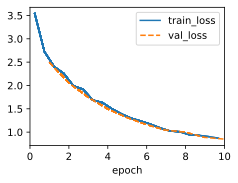

In [26]:
model = d2l.LinearRegression(lr=1e-5)
lr_data = LinearRegressionData(nInputs,data_matrix, num_train=train_data.shape[0], num_val=val_data.shape[0])
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, lr_data)

## Checar a estimativa de erro

### Valor ideal dos pesos

In [27]:
#W_optimal = inv (XT X) XT Y

Xb = tf.concat((data_matrix[:,0:nInputs], tf.ones((6497, 1),dtype=tf.float32)),axis=1)
Y = data_matrix[:,nInputs]
#quad=tf.matmul(tf.transpose(Xb),Xb)
#quad
W_opt = tf.linalg.matvec(tf.linalg.matmul(tf.linalg.inv(tf.matmul(tf.transpose(Xb),Xb)),tf.transpose(Xb)),Y)
#yhat=tf.linalg.matvec(Xb,W)
#yhat[0:5]
W_opt

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 8.72335315e-01, -1.47832900e-01, -3.49722892e-01, -6.20203197e-01,
        4.83390912e-02,  1.57778845e+01,  4.52350266e-03, -1.47363590e-03,
       -6.35376282e+01,  3.34257901e-01,  6.72223210e-01,  2.66080022e-01,
        6.30760193e+01], dtype=float32)>

### Calculando a precisão de acerto

In [28]:
predictions = tf.transpose(model.call(val_data_matrix[:,:nInputs]))[0]
num_cases = len(predictions)
goal = val_data_matrix[:,nInputs]
trivial = tf.reduce_mean(goal)
kicks = tf.convert_to_tensor([random.randint(1,7) for _ in range(num_cases)], dtype=tf.float32)

mean_error = float(tf.keras.metrics.mean_absolute_error(goal,predictions))
quadratic_error = float(tf.keras.metrics.mean_squared_error(goal,predictions))
mean_error_trivial = float(tf.keras.metrics.mean_absolute_error(goal,trivial))
quadratic_error_trivial = float(tf.keras.metrics.mean_squared_error(goal,trivial))
mean_error_random = float(tf.keras.metrics.mean_absolute_error(goal,kicks))
quadratic_error_random = float(tf.keras.metrics.mean_squared_error(goal,kicks))
pd.DataFrame([
    [mean_error,quadratic_error],
    [mean_error_trivial,quadratic_error_trivial],
    [mean_error_random,quadratic_error_random]
    ],
    columns=['Erro médio absuluto','Erro quadrático médio'],
    index=['Regressão Linear','Preditor Trivial','Preditor Aleatório'])
val_data_matrix

<tf.Tensor: shape=(1300, 13), dtype=float32, numpy=
array([[ 0.   ,  8.2  ,  0.39 , ...,  0.99 ,  9.8  ,  3.   ],
       [ 1.   ,  7.4  ,  0.25 , ...,  0.37 , 11.5  ,  5.   ],
       [ 1.   ,  5.6  ,  0.49 , ...,  0.9  , 13.7  ,  5.   ],
       ...,
       [ 1.   ,  8.6  ,  0.485, ...,  0.38 , 12.4  ,  3.   ],
       [ 1.   ,  6.5  ,  0.32 , ...,  0.6  , 12.   ,  5.   ],
       [ 1.   ,  6.2  ,  0.25 , ...,  0.51 ,  9.2  ,  3.   ]],
      dtype=float32)>

### Calculando o erro médio

In [29]:
def getAccuracy(target):
    return (len([0 for x in abs(goal - tf.round(target)) if x == 0])/num_cases) * 1e2

accuracy = getAccuracy(predictions)
trivial_accuracy = getAccuracy(trivial)
random_accuracy = getAccuracy(kicks)

print(f'Precisão do modelo linar: {accuracy:.2f}%')
print(f'Precisão do preditor trivial: {trivial_accuracy:.2f}%')
print(f'Precisão do preditor aleatório: {random_accuracy:.2f}%')

Precisão do modelo linar: 43.08%
Precisão do preditor trivial: 43.15%
Precisão do preditor aleatório: 12.85%


### Correlação entre saída desejada e obtida

In [30]:
correlation = pd.DataFrame()
correlation['Goal'] = goal.numpy()
correlation['Predictions'] = predictions.numpy()
#correlation['Trivial'] = trivial.numpy() # como é constante não há correlação
correlation['Aleatório'] = kicks.numpy()
correlation.corr()

,Goal,Predictions,Aleatório
Goal,1.000000,0.177792,-0.002132
Predictions,0.177792,1.000000,-0.012699
Aleatório,-0.002132,-0.012699,1.000000


### Matriz de Confusão

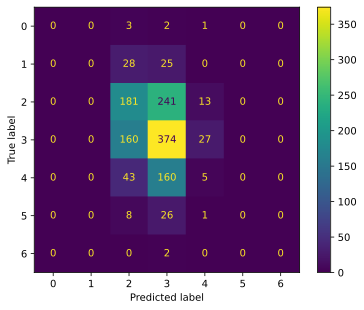

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(goal, tf.round(predictions))).plot()
plt.grid(False)
plt.show()